# Cox Proportional Hazard Model
In this notebook, we will be performing Cox Regression using static variables to predict the risk of patients' survival. First, we load our training and test data and perform any necessary featuring to both predictive variables and targets. This will involve one-hot encoding any categorical variables, and calculating time to death/censuring.

In [108]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import os
from datetime import datetime
import math
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines import WeibullAFTFitter
from sksurv.linear_model import CoxPHSurvivalAnalysis, IPCRidge
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sksurv.metrics import concordance_index_censored
from datetime import datetime, timedelta
import seaborn as sns
import time
import json

In [2]:
# Access google drive data
data_dir = r"C:\Users\mgaut\Documents\Info_Vis_Project\Data"
train_path = os.path.join(data_dir, 'static_train_data.csv')
test_path = os.path.join(data_dir, 'static_test_data.csv')
val_path = os.path.join(data_dir, 'static_val_data.csv')


In [3]:
df = pd.read_csv(os.path.join(data_dir, 'static_patient_data_v2.csv'),
                 parse_dates = ['intime', 'outtime', 'DOD','DOD_HOSP','DOD_SSN'],
                 dtype={
                     'days_live':'Int64'
                     ,'years_live': 'Int64'
                     }
                 )
df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'ICUSTAY_AGE_GROUP', 'intime',
       'DOD', 'hospital_deathtime', 'EXPIRE_FLAG', 'DOD_SSN', 'DOD_HOSP',
       'hospital_expire_flag', 'intime_1', 'outtime', 'ICUSTAY_EXPIRE_FLAG',
       'gender', 'icu_admit_age', 'admit_age', 'admittime'],
      dtype='object')

In [4]:
patient_df = df[df['ICUSTAY_AGE_GROUP'] == 'adult']
patient_df['survival_time'] = (patient_df['DOD'] - patient_df['intime'])/np.timedelta64(1,'D')
patient_df['length_stay'] = (patient_df['outtime'] - patient_df['intime'])/np.timedelta64(1,'D')
max_time = max(patient_df.survival_time.to_list())
patient_df['survival_time'] = patient_df['survival_time'].fillna(patient_df.survival_time.max())
patient_df['time'] = patient_df.apply(lambda row: math.floor(max(row.survival_time, row.length_stay)), axis=1)
patient_df['age_group'] = patient_df['admit_age'].map(lambda x: str(math.floor(x/10)*10) + 's')

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

## Cox Regression v.s. Kaplan Meier
To start, we will look at two different approaches for survival analysis - Kaplan Meier method and the Cox Proportional Hazard Model. First, the Kaplan Meier method is univariate, so this process will involve grouping patients by conditions (age group, illness, ethnicity, etc.) and generating a univariate regression for patients in each group by calculating the hazard at each time period (days). Second, the Cox Proportional Hazard Model is a multivariate model in which we calculate the relative hazard of each feature (or Covariate) and use these covariates to fit a exponential survival regression for each patient. 

### Kaplan Meier Model

In [5]:
kmf = KaplanMeierFitter()
kmf.fit(durations = patient_df['time'], event_observed = patient_df['EXPIRE_FLAG'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 50711 total observations, 28661 right-censored observations>

In [6]:
print("Median Survival Time: ", kmf.median_survival_time_)

Median Survival Time:  inf


In [7]:
kmf.survival_function_.reset_index()

timeline  KM_estimate
0          0.0     0.982923
1          1.0     0.968429
2          2.0     0.956656
3          3.0     0.948256
4          4.0     0.940900
...        ...          ...
2892    4131.0     0.565262
2893    4140.0     0.565242
2894    4164.0     0.565223
2895    4292.0     0.565203
2896    4332.0     0.565183

[2897 rows x 2 columns]

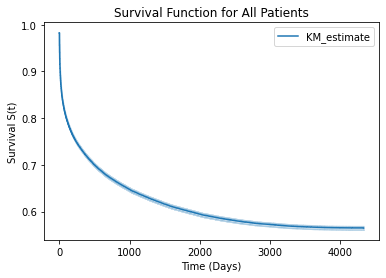

In [8]:
kmf.plot()
plt.title('Survival Function for All Patients')
plt.xlabel('Time (Days)')
plt.ylabel('Survival S(t)')
plt.show()

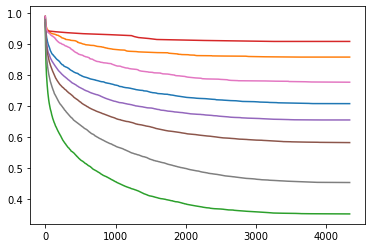

In [9]:
kmodel_df = patient_df[['time', 'EXPIRE_FLAG', 'age_group']]
age_groups = set(patient_df.age_group.to_list())

for age in age_groups:
  data = kmodel_df[kmodel_df.age_group==age]
  kmf = KaplanMeierFitter()
  kmf.fit(durations = data['time'], event_observed = data['EXPIRE_FLAG'])
  surv = kmf.survival_function_.reset_index()
  plt.plot(surv.timeline, surv.KM_estimate)
plt.show()

In [10]:
model_df = patient_df[['time', 'EXPIRE_FLAG', 'admit_age', 'gender']]
input_df = pd.get_dummies(model_df, drop_first= True)
train_df, test_df = train_test_split(input_df, test_size = 0.3)

### Cox Proportional Hazard

In [11]:
cph = CoxPHFitter()
cph.fit(train_df, "time", event_col="EXPIRE_FLAG")

<lifelines.CoxPHFitter: fitted with 35497 total observations, 20083 right-censored observations>

In [12]:
test_curves = cph.predict_survival_function(test_df)
test_pred = cph.predict_expectation(test_df)
test_df['prediction'] = test_pred

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Survival S(t)')

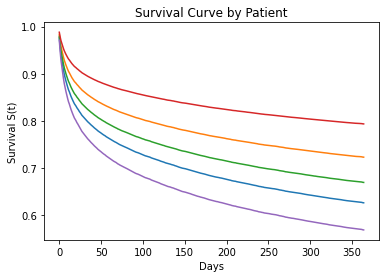

In [13]:
curve_example = test_curves.iloc[0:365, 0:5]
curve_example.plot()
plt.legend().remove()
plt.title('Survival Curve by Patient')
plt.legend().remove()
plt.xlabel('Days')
plt.ylabel('Survival S(t)')

In [14]:
math.sqrt(mean_squared_error(test_df.time, test_df.prediction))

1874.5059894650071

### Cox Regression
Now we will expand our Cox Regression to include both demographic and diagnosis data. We will need to one-hot encode categorical variables, and scale numeric variables to be in same number range as encoding (0 to 1).

In [15]:
train_data = pd.read_csv(train_path)
train_data['time'] = pd.to_timedelta(train_data['time_until_death']) / np.timedelta64(1, 'D')

# Set censorship to max survival
train_data.time = train_data.time.fillna(train_data.time.max()).apply(math.floor)
# Select variables that will be used for modeling
train_input = pd.concat([train_data[['time', 'anytime_expire_flag', 'icu_admit_age']],
                         train_data.loc[:, 'female':'TSICU'],
                         train_data.loc[:, 'cardio' :'other']], axis = 1)
# Scale Numerical variables to match range of one-hot variables
scaler = MinMaxScaler()
train_input.icu_admit_age = scaler.fit_transform(train_input.icu_admit_age.values.reshape(-1, 1))

# Most Correlated w/ targets: CSRU, MICU, icu_admit_age, infection, failure, cancer
# Drop columns: cardio, 

In [16]:
cm = sns.light_palette('green', as_cmap=True)
train_input.corr().abs().style.background_gradient(cmap=cm, axis=0)

In [17]:
test_data = pd.read_csv(test_path)
test_data['time'] = pd.to_timedelta(test_data['time_until_death']) / np.timedelta64(1, 'D')
test_data.time = test_data.time.fillna(test_data.time.max()).apply(math.floor)
test_input = pd.concat([test_data[['time', 'anytime_expire_flag', 'icu_admit_age']],
                        test_data.loc[:, 'female':'TSICU'],
                        test_data.loc[:, 'cardio' :'other']], axis = 1)
scaler = MinMaxScaler()
test_input.icu_admit_age = scaler.fit_transform(test_input.icu_admit_age.values.reshape(-1, 1))


In [18]:
# Fit Cox regression to determine which variables have strong coefficient
coxph = CoxPHFitter()
coxph.fit(train_input, 'time', event_col='anytime_expire_flag')
cox_vars = coxph.summary.coef.abs()
strong_vars = cox_vars[cox_vars > 0.2].index.to_list()

# Fit new model with strong variables
n_train_input = train_input[['time', 'anytime_expire_flag'] + strong_vars]
n_coxph = CoxPHFitter()
n_coxph.fit(n_train_input, 'time', event_col='anytime_expire_flag')

<lifelines.CoxPHFitter: fitted with 23392 total observations, 14239 right-censored observations>

In [52]:
cox_vars.sort_values(ascending=False).index[:10].to_list()

['icu_admit_age',
 'cancer',
 'CSRU',
 'failure',
 'infection',
 'brain',
 'respiratory',
 'pain',
 'TSICU',
 'other']

Text(0.5, 1.0, 'Strongest Variables')

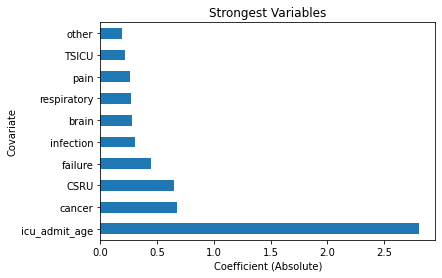

In [19]:
# TODO: Generate graph of the strongest variables for Cox Regression
cox_vars.sort_values(ascending= False)[:10].plot.barh()
plt.xlabel('Coefficient (Absolute)')
plt.ylabel('Covariate')
plt.title('Strongest Variables')

In [20]:
test_curve = n_coxph.predict_survival_function(test_input[['time', 'anytime_expire_flag'] + strong_vars])
test_curve

0         1         2         3         4         5         6     \
0.0     0.984189  0.967852  0.968501  0.983603  0.980652  0.960893  0.976423   
1.0     0.974124  0.947666  0.948713  0.973169  0.968372  0.936484  0.961511   
2.0     0.966111  0.931752  0.933106  0.964866  0.958616  0.917320  0.949694   
3.0     0.959678  0.919077  0.920672  0.958202  0.950797  0.902109  0.940244   
4.0     0.953772  0.907517  0.909328  0.952085  0.943629  0.888276  0.931593   
...          ...       ...       ...       ...       ...       ...       ...   
4110.0  0.640034  0.400548  0.408146  0.629442  0.578662  0.327272  0.512704   
4121.0  0.639989  0.400490  0.408088  0.629396  0.578612  0.327214  0.512650   
4140.0  0.639943  0.400432  0.408030  0.629350  0.578562  0.327156  0.512595   
4164.0  0.639898  0.400373  0.407972  0.629303  0.578512  0.327098  0.512541   
4292.0  0.639853  0.400315  0.407914  0.629257  0.578462  0.327040  0.512487   

            7         8         9     ...      7300      7301      7302  \
0.0     0.981717  0.990854  0.968992  ...  0.990513  0.996762  0.986334   
1.0     0.970102  0.984999  0.949504  ...  0.984442  0.994680  0.977618   
2.0     0.960868  0.980319  0.934129  ...  0.979590  0.993009  0.970671   
3.0     0.953465  0.976551  0.921877  ...  0.975684  0.991660  0.965088   
4.0     0.946674  0.973081  0.910697  ...  0.972088  0.990416  0.959958   
...          ...       ...       ...  ...       ...       ...       ...   
4110.0  0.596513  0.773158  0.413979  ...  0.765755  0.913202  0.680256   
4121.0  0.596464  0.773127  0.413921  ...  0.765723  0.913189  0.680214   
4140.0  0.596415  0.773095  0.413863  ...  0.765690  0.913176  0.680173   
4164.0  0.596366  0.773064  0.413805  ...  0.765658  0.913163  0.680131   
4292.0  0.596317  0.773032  0.413747  ...  0.765626  0.913149  0.680089   

            7303      7304      7305      7306      7307      7308      7309  
0.0     0.984499  0.990513  0.952242  0.993176  0.986338  0.987299  0.982995  
1.0     0.974628  0.984442  0.922655  0.988799  0.977625  0.979193  0.972180  
2.0     0.966768  0.979590  0.899548  0.985296  0.970680  0.972727  0.963576  
3.0     0.960458  0.975684  0.881285  0.982472  0.965099  0.967530  0.956674  
4.0     0.954663  0.972088  0.864736  0.979869  0.959970  0.962751  0.950339  
...          ...       ...       ...       ...       ...       ...       ...  
4110.0  0.645696  0.765755  0.254062  0.825529  0.680341  0.699148  0.618639  
4121.0  0.645651  0.765723  0.254007  0.825504  0.680300  0.699108  0.618592  
4140.0  0.645606  0.765690  0.253952  0.825479  0.680258  0.699069  0.618545  
4164.0  0.645561  0.765658  0.253897  0.825453  0.680216  0.699029  0.618498  
4292.0  0.645516  0.765626  0.253842  0.825428  0.680175  0.698989  0.618451  

[2268 rows x 7310 columns]

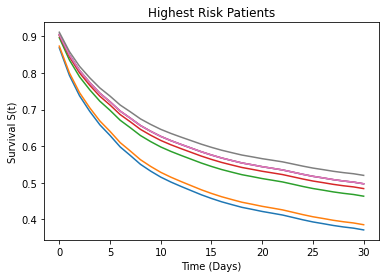

In [21]:
# test_curve
# Level 1: 100-90
# Level 2: 90-80
# Level 3: 80-70
# Level 4: 70-60
# Level 5: <60

test_curve.T.sort_values(by=30).T.iloc[:31, :8].plot()
plt.ylabel('Survival S(t)')
plt.xlabel('Time (Days)')
plt.title('Highest Risk Patients')
plt.legend().remove()

In [22]:
worst = test_curve.T.sort_values(by=30).T.iloc[:31, :8].T.index.values.tolist()
test_data[test_data.index.isin(worst)].loc[:,'SICU':]

SICU  TSICU                                          diagnosis  \
813      1      0                                    LUNG CANCER SDA   
910      1      0                    CONGESTIVE HEART FAILURE SEPSIS   
1489     0      0                              LUNG CANCER PNEUMONIA   
1669     0      0  CONGESTIVE HEART FAILURE  AML  ACUTE MYELOGENO...   
1792     0      0    CHRONIC MYELOGENOUS LEUKEMIA FEVER HYPERKALEMIA   
4153     0      0                      PNEUMONIA RESPIRATORY FAILURE   
4353     0      0                    SHORTNESS OF BREATH LUNG CANCER   
6649     0      0                         HYPERCALCEMIA  LUNG CANCER   

     admission_type            dischtime  cardio  infection  brain  mental  \
813        ELECTIVE  2113-10-19 15:30:00       0          0      0       0   
910       EMERGENCY  2118-11-21 16:00:00       1          1      0       0   
1489      EMERGENCY  2135-01-26 12:00:00       0          1      0       0   
1669      EMERGENCY  2191-10-06 16:29:00       1          0      0       0   
1792      EMERGENCY  2136-02-21 15:30:00       0          1      0       0   
4153      EMERGENCY  2121-03-07 17:40:00       0          1      0       0   
4353      EMERGENCY  2196-08-13 13:18:00       0          0      0       0   
6649      EMERGENCY  2180-05-06 13:00:00       0          0      0       0   

      gastro  ...  blood  acute  failure  cancer  back  bone  pain  other  \
813        0  ...      0      0        0       1     0     0     0      0   
910        0  ...      0      0        1       0     0     0     0      0   
1489       0  ...      0      0        0       1     0     0     0      0   
1669       0  ...      0      1        1       1     0     0     0      0   
1792       0  ...      1      0        0       1     0     0     0      0   
4153       0  ...      0      0        1       0     0     0     0      0   
4353       0  ...      0      0        0       1     0     0     0      0   
6649       0  ...      0      0        0       1     0     0     0      0   

      totalcats  time  
813           2  4332  
910           3   293  
1489          3    21  
1669          5  4332  
1792          3  1232  
4153          3   184  
4353          2     7  
6649          2  1357  

[8 rows x 23 columns]

In [23]:
def classify_risk(score):
    
    if score >= 0.9:
        risk = 'Level 1'
    elif score >= 0.8:
        risk = 'Level 2'
    elif score >= 0.7:
        risk = 'Level 3'
    elif score >= 0.6:
        risk = 'Level 4'
    else:
        risk = 'Level 5'
    
    return risk
    

In [24]:
# level_counts = Counter(test_curve.T[30].apply(classify_risk))
# levels, counts = level_counts.keys(), level_counts.values()
# test_curve.T[30].apply(classify_risk)
risk_levels = test_curve.applymap(classify_risk)
levels_risk = risk_levels.T[30]
test_levels = pd.concat([test_data, levels_risk], axis=1)

In [25]:
test_levels.groupby(30).agg({'icu_admit_age':['mean', 'min', 'max']})

icu_admit_age        
                 mean min max
30                           
Level 1     50.045455  15  83
Level 2     68.460740  39  89
Level 3     79.795357  50  89
Level 4     82.902542  64  89
Level 5     83.392857  73  88

In [26]:
test_levels.groupby(30).agg({'totalcats':['mean','median','min','max']})

totalcats               
             mean median min max
30                              
Level 1  1.102417    1.0   0   5
Level 2  1.235978    1.0   0   5
Level 3  1.347377    1.0   0   5
Level 4  1.745763    2.0   1   5
Level 5  2.571429    2.5   1   5

Text(0, 0.5, 'Patients')

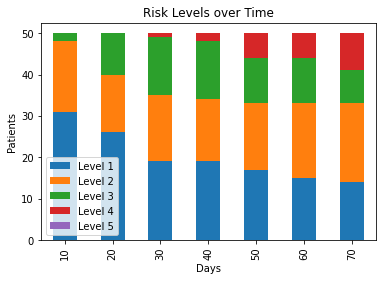

In [27]:
risk_counts = risk_levels.iloc[:365,:50].apply(Counter, axis = 1)
count_risks = pd.DataFrame.from_dict(risk_counts.to_list(), orient='columns')
count_risks[count_risks.index.isin([10, 20, 30, 40, 50, 60, 70])].plot.bar(stacked = True)
plt.title('Risk Levels over Time')
plt.xlabel('Days')
plt.ylabel('Patients')

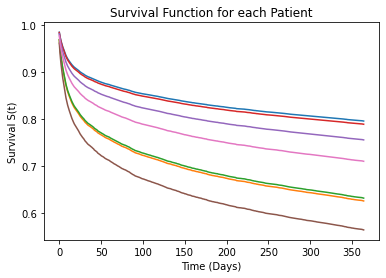

In [28]:
test_curve.iloc[0:365, 0:7].plot()
plt.title('Survival Function for each Patient')
plt.xlabel('Time (Days)')
plt.ylabel('Survival S(t)')
plt.legend().remove()

In [29]:
# math.sqrt(mean_squared_error(test_data.time, test_data.prediction))
n_coxph.score(test_input[['time', 'anytime_expire_flag'] + strong_vars], scoring_method= 'concordance_index')

# Run against test set

0.6834075745949734

In [30]:
# Finally, we run against validation
val_data = pd.read_csv(val_path)
val_data['time'] = pd.to_timedelta(val_data['time_until_death']) / np.timedelta64(1, 'D')
val_data.time = val_data.time.fillna(val_data.time.max()).apply(math.floor)
val_input = pd.concat([val_data[['time', 'anytime_expire_flag', 'icu_admit_age']],
                       val_data.loc[:, 'female':'TSICU'],
                       val_data.loc[:, 'cardio' :'other']], axis = 1)
scaler = MinMaxScaler()
val_input.icu_admit_age = scaler.fit_transform(val_input.icu_admit_age.values.reshape(-1, 1))
strong_val = val_input[['time', 'anytime_expire_flag'] + strong_vars]

n_coxph.score(strong_val, scoring_method='concordance_index')

0.6932407692003139

# Accelerated Failure Time Model (AFT)
Next we will work with the AFT model to try to handle non-constant hazards, and improve time to event prediction.

In [31]:
aft_input = train_input[train_input.time > 0]
# train_input.time = train_input.time.apply(lambda x: 0.1 if x==0 else x)

aft = WeibullAFTFitter()
aft.fit(aft_input, 'time', event_col='anytime_expire_flag')

<lifelines.WeibullAFTFitter: fitted with 22923 total observations, 14239 right-censored observations>

Text(0.5, 0, '')

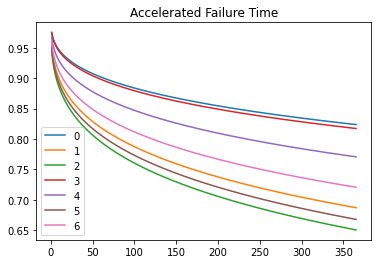

In [32]:
test_pred_aft = aft.predict_survival_function(test_input[test_input.time > 0])
test_pred_aft.iloc[0:365, 0:7].plot()
plt.title('Accelerated Failure Time')
plt.xlabel('')

In [33]:
aft.score(val_input[val_input.time > 0], scoring_method='concordance_index')
# aft.predict_expectation(test_input)

0.6984475742640722

# Boosting for Prediction
We will need to incorporate ensemble modeling if we are going to optimize time to event prediction. For this we are going to use the XGBoost library with both Cox Proportional Hazards and Accelerated Failure Time.

## Cox Regression
First we will need to reformat our data to meet the input and target requirements for XGBoost

In [105]:
x_train = train_input

# Make dates of censoring
censor_date = x_train.time.max()
x_target = x_train.time.apply(lambda x: -x if x == censor_date else x)

# Reformat data to work with XGBoost format
x_input = x_train.drop(['time', 'anytime_expire_flag'], axis=1)
D_train = xgb.DMatrix(x_input, label = x_target)

param ={
    'eta' : 0.01,
    'booster' : 'gbtree',
    'objective' : 'survival:cox',
    'eval-metric' : 'cox-nloglik',
    'max_depth':10,
    'gamma':1
}

rounds = 50

cox = xgb.train(param, D_train, rounds)

[16:15:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { eval-metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [106]:
# Reformat Test data
x_test = test_input

# Make dates of censoring
test_censor = x_test.time.max()
x_test_target = x_test.time.apply(lambda x: -x if x == test_censor else x)

# Reformat data to work with XGBoost format
x_test_input = x_test.drop(['time', 'anytime_expire_flag'], axis=1)
D_test = xgb.DMatrix(x_test_input, label=x_test_target)

In [107]:
pred = cox.predict(D_test)
event = test_input.anytime_expire_flag.apply(lambda x: False if x==0 else True)
concordance_index_censored(event, test_input.time, pred)

(0.6842186210346473, 11170896, 5142454, 48845, 4545)

Now we will try with scikit-survival

In [37]:
s_input = train_input.loc[:, 'icu_admit_age':]
s_target = train_input[['anytime_expire_flag', 'time']]
s_target.anytime_expire_flag = s_target.anytime_expire_flag.apply(lambda x: False if x==0 else True)
s_target = s_target.to_records(index=False)

s_test = test_input.loc[:, 'icu_admit_age':]
s_test_target = test_input[['anytime_expire_flag', 'time']]
s_test_target.anytime_expire_flag = s_test_target.anytime_expire_flag.apply(lambda x: False if x==0 else True)
s_test_target = s_test_target.to_records(index=False)

coxph = CoxPHSurvivalAnalysis()
estimator = coxph.fit(s_input, s_target)

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [38]:
s_vars = pd.Series(estimator.coef_, index=s_input.columns).abs()
strong_vars = s_vars[s_vars>=0.2].index.values.tolist()
strong_vars

['icu_admit_age',
 'CSRU',
 'TSICU',
 'infection',
 'brain',
 'respiratory',
 'failure',
 'cancer',
 'pain']

In [39]:
estimator.score(s_test, s_test_target)

0.6878381231857951

In [40]:
n_estimator = CoxPHSurvivalAnalysis().fit(s_input[strong_vars], s_target)

In [41]:
n_estimator.score(s_test[strong_vars], s_test_target)

0.6834106915361906

In [95]:
a_train = train_input[train_input.time > 0]
a_input = a_train.loc[:, 'icu_admit_age':]
a_target = a_train[['anytime_expire_flag', 'time']]
a_target.anytime_expire_flag = a_target.anytime_expire_flag.apply(lambda x: False if x==0 else True)
a_target = a_target.to_records(index=False)
# aft = IPCRidge().fit(a_input, a_target)

C:\Users\mgaut\Anaconda3\envs\infovis\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Now we will try Boosting and Random Forest using the scikit-survival library

In [43]:
# Need to perform GridSearchCV for learning rate & number of trees
start = time.time()
cox_boost = GradientBoostingSurvivalAnalysis(
    n_estimators = 50,
    max_depth = 5
)
cox_boost.fit(s_input, s_target)
end = time.time()

total = end - start
print(str(int(total/60)) + 'm ' + str(total % 60)+'s')

6m 49.76271629333496s


In [44]:
cox_boost.score(s_test, s_test_target)

0.6889781291568766

In [45]:
cox_rf = RandomSurvivalForest()
cox_rf.fit(s_input, s_target)

RandomSurvivalForest()

In [46]:
cox_rf.score(s_test, s_test_target)

0.6841797509441735